In [15]:
import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src import load_data
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Fonction pour calculer RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Fonction pour calculer MAPE
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100


In [16]:
data = load_data('../data/processed/processed_data.csv')

data["date"] = pd.to_datetime(data["date"])
data.set_index("date",inplace=True)

data.head()
# Préparer les variables indépendantes et la cible
#X= data.drop(columns=['Appliances', 'date'], axis=1)
#y = data['Appliances']

#X_test = data_test.drop(columns=['Appliances', 'date'], axis=1)
 #y_test = data_test['Appliances']
train_index = (data.index <= "2016-04-27 18:00:00").sum()
X_train = data.drop(columns=['Appliances'], axis=1).iloc[:train_index]
y_train = data['Appliances'].iloc[:train_index]



Données chargées avec succès.


In [17]:
# Initialisation des modèles
xgb_model = XGBRegressor(n_estimators=150, learning_rate=0.05, max_depth=6, random_state=42)

cart_model = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
cart_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# 3. Configurer la Random Search
cart_model = DecisionTreeRegressor()
random_search = RandomizedSearchCV(
    estimator=cart_model,
    param_distributions=cart_param_grid,
    n_iter=20,  # Nombre d'itérations pour la recherche
    scoring='neg_mean_squared_error',
    cv=3,  # Validation croisée à 3 plis
    n_jobs=-1,
    random_state=42
)

# 4. Ajustement du modèle
random_search.fit(X_train, y_train)
best_params_cart=random_search.best_params_
best_params_cart

/home/abdoulayediallo/.local/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/abdoulayediallo/.local/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/abdoulayediallo/.local/lib/python3.13/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/abdoulayediallo/.local/lib/python3.13/site-pac

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 3}

In [19]:
from sklearn.tree import DecisionTreeRegressor

def boosting_with_residuals(X, y, strong_model, train_index, total_steps, cart_max_depth=3):
    """
    Implémente un modèle de boosting en ajoutant un apprenant final basé sur CART.
    
    Parameters:
    - X : pd.DataFrame, variables explicatives.
    - y : pd.Series, variable cible.
    - strong_model : modèle fort préalablement entraîné.
    - train_index : int, index de début pour les données d'entraînement.
    - total_steps : int, nombre de pas à prédire à chaque itération.
    - cart_max_depth : int, profondeur maximale du modèle CART.
    
    Returns:
    - y_pred : Liste des prédictions combinées (strong_model + CART).
    """
    y_pred = []
    
    for j in range(0, len(X) - train_index, total_steps):
        # Entraînement du modèle fort sur les données actuelles
        X_train, y_train = X.iloc[:train_index + j], y.iloc[:train_index + j]
        X_test = X.iloc[train_index + j:train_index + j + total_steps]
        y_test = y.iloc[train_index + j:train_index + j + total_steps]
        
        # Entraînement du modèle fort (e.g., un modèle préalablement entraîné comme XGBoost, etc.)
        strong_model.fit(X_train, y_train)
        y_pred_strong_train = strong_model.predict(X_train)
        y_pred_strong_test = strong_model.predict(X_test)
        
        # Calcul des résidus (pondérés ou non)
        residuals_train = y_train - y_pred_strong_train
        residuals_test = y_test - y_pred_strong_test
        
        # Entraînement du modèle CART sur les résidus
        cart_model = DecisionTreeRegressor(max_depth=cart_max_depth)
        cart_model.fit(X_train, residuals_train)
        residuals_pred_test = cart_model.predict(X_test)
        
        # Combinaison des prédictions
        final_pred_test = y_pred_strong_test + residuals_pred_test
        y_pred.extend(final_pred_test)
    
    return y_pred


In [20]:


def boosting_with_residuals(X, y, strong_model, train_index, total_steps,cart_max_depth=3):
    """
    Implémente un modèle de boosting en ajoutant un apprenant final basé sur CART.
    
    Parameters:
    - X : pd.DataFrame, variables explicatives.
    - y : pd.Series, variable cible.
    - strong_model : modèle fort préalablement entraîné.
    - train_index : int, index de début pour les données d'entraînement.
    - total_steps : int, nombre de pas à prédire à chaque itération.
    - cart_max_depth : int, profondeur maximale du modèle CART.
    
    Returns:
    - y_pred : Liste des prédictions combinées (strong_model + CART).
    """
    y_pred = []
    
    for j in range(0, len(X) - train_index, total_steps):
        # Entraînement du modèle fort sur les données actuelles
        X_train, y_train = X.iloc[:train_index + j], y.iloc[:train_index + j]
        X_test = X.iloc[train_index + j:train_index + j + total_steps]
        y_test = y.iloc[train_index + j:train_index + j + total_steps]
        
        strong_model.fit(X_train, y_train)
        y_pred_strong_train = strong_model.predict(X_train)
        y_pred_strong_test = strong_model.predict(X_test)
        
        # Calcul des résidus (pondérés ou non)
        residuals_train = y_train - y_pred_strong_train
        residuals_test = y_test - y_pred_strong_test
        
        # Entraînement du modèle CART sur les résidus
        cart_model = DecisionTreeRegressor(max_depth=3)
        cart_model.fit(X_train, residuals_train)
        residuals_pred_test = cart_model.predict(X_test)
        
        # Combinaison des prédictions
        final_pred_test = y_pred_strong_test + residuals_pred_test
        y_pred.extend(final_pred_test)
    
    return y_pred


In [26]:
train_index = (data.index <= "2016-04-27 18:00:00").sum()
X_train = data.drop(columns=['Appliances'], axis=1).iloc[:train_index]
y_train = data['Appliances'].iloc[:train_index]
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_dist = {
    'n_estimators': np.arange(50, 151, 10),  
    'learning_rate': np.arange(0.01, 0.16, 0.01),  
    'max_depth': np.arange(3, 11, 1),  
    'min_child_weight': np.arange(1, 11, 1),  
    'subsample': np.arange(0.5, 1.1, 0.1),  # Fraction des échantillons entre 0.5 et 1.0 avec un pas de 0.1
    'colsample_bytree': np.arange(0.5, 1.1, 0.1),  # Fraction des colonnes par arbre entre 0.5 et 1.0
    'gamma': np.arange(0, 0.51, 0.05),  # Paramètre gamma entre 0 et 0.5 avec un pas de 0.05
    'scale_pos_weight': [1, 5, 10, 20],  
}

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

best_params = random_search.best_params_

# Création du modèle avec les meilleurs paramètres
optimized_model = XGBRegressor(**best_params)

Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


RMSE final : 89.8525
MAPE final : 54.3584%


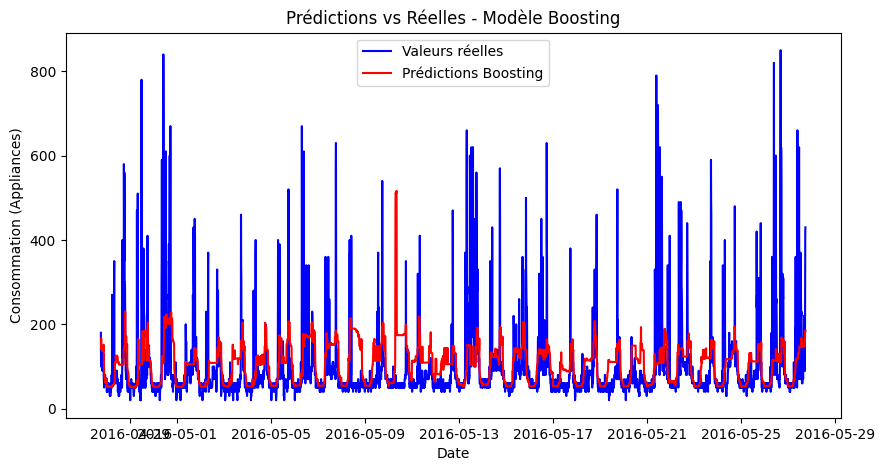

In [28]:
best_params = random_search.best_params_

# Création du modèle avec les meilleurs paramètres
optimized_model = XGBRegressor(**best_params)
y=data["Appliances"]
X=data.drop(columns=["Appliances"],axis=1)
X_test, y_test = data.iloc[train_index:], data['Appliances'].iloc[train_index:]
#xgb_model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)

# Boosting avec résidus
y_pred = boosting_with_residuals(X ,y,optimized_model, train_index, 144)
# Évaluation des performances (RMSE et MAPE)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
mape_final = np.mean(np.abs((y_test- y_pred) / y_test)) * 100
#xgb_model.fit(X_train,y_train)
#rmse_bost=np.sqrt(mean_squared_error(y_test,xgb_model.predict(X_test) ))
# Affichage des résultats d'évaluation
#print(rmse_bost)
print(f"RMSE final : {rmse_final:.4f}")
print(f"MAPE final : {mape_final:.4f}%")

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Valeurs réelles', color='blue')
plt.plot(y_test.index, y_pred, label='Prédictions Boosting', color='red')
plt.legend()
plt.title("Prédictions vs Réelles - Modèle Boosting")
plt.xlabel("Date")
plt.ylabel("Consommation (Appliances)")
plt.show()

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}
